In [1]:
library(igraph)
library(neat)
library(utils)
library(reshape2)
library(ggplot2)
library(pheatmap)
library(viridis)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: viridisLite


In [3]:
d=read.delim(gzfile("GENIE3.top10_target_ranks.ranked_regulator_target_interactions.with_communities.tsv.gz"),sep="\t",stringsAsFactors=FALSE)
d=subset(d,community %in% as.character(as.roman(1:11)))
head(d)

,regulatoryGene,targetGene,weight,regulator_rank,target_rank,mutual_rank,regulator_community,target_community,community
1,Pp3c17_930.mRNA,Pp3s340_10.mRNA,0.067780515,1,1,1.000000,I,I,I
3,Pp3c2_25760.mRNA,Pp3s340_10.mRNA,0.015763051,58,3,13.190906,I,I,I
4,Pp3c19_10050.mRNA,Pp3s340_10.mRNA,0.009034066,496,7,58.923679,I,I,I
6,Pp3c2_36690.mRNA,Pp3s340_10.mRNA,0.009846669,50,6,17.320508,I,I,I
11,Pp3c17_930.mRNA,Pp3c19_7324.mRNA,0.047101805,2,1,1.414214,I,I,I
13,Pp3c2_25760.mRNA,Pp3c19_7324.mRNA,0.012256680,111,6,25.806976,I,I,I


In [4]:
n=read.delim("GENIE3.top10_target_ranks.communities_PLM.with_node_centralities.csv",sep=";",stringsAsFactors=FALSE)
n=subset(n,community %in% as.character(as.roman(1:11)))
head(n)

geneid,community,degree_centrality,betweenness_centrality,eigenvector_centrality,local_reaching_centrality,centrality_rank
Pp3c27_3080.mRNA,I,109,0,0.00000000,0.9977499,1
Pp3c11_23290.mRNA,I,552,3190,0.05359921,0.9971070,2
Pp3c7_2300.mRNA,I,505,7529,0.02518149,0.9971070,3
Pp3c17_23620.mRNA,I,490,1988,0.05419710,0.9971070,4
Pp3c16_13280.mRNA,I,485,9982,0.05634423,0.9971070,5
Pp3c15_11610.mRNA,I,461,3734,0.04049888,0.9971070,6


In [5]:
G=graph_from_data_frame(d,directed = TRUE,vertices = n)

In [ ]:
com=sapply(as.character(as.roman(1:11)),function(i) n[n$community==i, "geneid"])

# Development

Using all DEGs from the set:

In [9]:
read_dge=function(p) {
    n=gsub(".dge.full.tsv.gz","",perl=TRUE,gsub("..\\/sleuth\\/gene_atlas\\/","",p,perl=TRUE))
    f=sprintf("../sleuth/gene_atlas/%s.dge.full.tsv.gz",n)
    d=read.delim(gzfile(f),sep="\t")
    d=transform(d,GENEID=as.character(d$GENEID),target_id=d$target_id)
    data.frame(comp=n,d)
}

In [10]:
DD=do.call(rbind.data.frame,lapply(list.files(path = "../sleuth/gene_atlas",pattern="*dge.full.tsv.gz"),read_dge))

In [11]:
DD=subset(DD,qval.lrt<0.1)

In [12]:
table(DD$comp,DD$b>0)

                   
                    FALSE TRUE
  brown_sporophytes  9009 8541
  gametophores       1761 3129
  green_sporophytes  3519 3767
  protonema          6957 5981
  spores             2332 1806

In [13]:
Lu=sapply(levels(DD$comp),function(x) {
    unique(as.character(subset(DD,comp==x & b>0)$target_id))
})
Ld=sapply(levels(DD$comp),function(x) {
    unique(as.character(subset(DD,comp==x & b<0)$target_id))
})
names(Lu)=paste(names(Lu),"up",sep=".")
names(Ld)=paste(names(Ld),"down",sep=".")
L=c(Lu,Ld)
str(L)

List of 10
 $ brown_sporophytes.up  : chr [1:8541] "Pp3c8_820.mRNA" "Pp3c8_3810.mRNA" "Pp3c23_10040.mRNA" "Pp3c13_13320.mRNA" ...
 $ gametophores.up       : chr [1:3129] "Pp3c5_16290.mRNA" "Pp3c1_430.mRNA" "Pp3c21_17370.mRNA" "Pp3c2_3460.mRNA" ...
 $ green_sporophytes.up  : chr [1:3767] "Pp3c1_11910.mRNA" "Pp3c10_16010.mRNA" "Pp3c8_1680.mRNA" "Pp3c3_37980.mRNA" ...
 $ protonema.up          : chr [1:5981] "Pp3c26_12890.mRNA" "Pp3c3_11940.mRNA" "Pp3c23_12060.mRNA" "Pp3c2_14620.mRNA" ...
 $ spores.up             : chr [1:1806] "Pp3c2_1270.mRNA" "Pp3c18_7090.mRNA" "Pp3c11_14770.mRNA" "Pp3c1_38210.mRNA" ...
 $ brown_sporophytes.down: chr [1:9009] "Pp3c15_21520.mRNA" "Pp3c17_2240.mRNA" "Pp3c17_5100.mRNA" "Pp3c6_12520.mRNA" ...
 $ gametophores.down     : chr [1:1761] "Pp3c20_13320.mRNA" "Pp3c25_7490.mRNA" "Pp3c27_4530.mRNA" "Pp3c14_15830.mRNA" ...
 $ green_sporophytes.down: chr [1:3519] "Pp3c23_4600.mRNA" "Pp3c7_19260.mRNA" "Pp3c7_10860.mRNA" "Pp3c2_620.mRNA" ...
 $ protonema.down        : ch

In [14]:
test.td = neat(alist = L, blist = com, network = G, nettype = 'undirected', nodes = n$geneid, alpha = 0.05) 

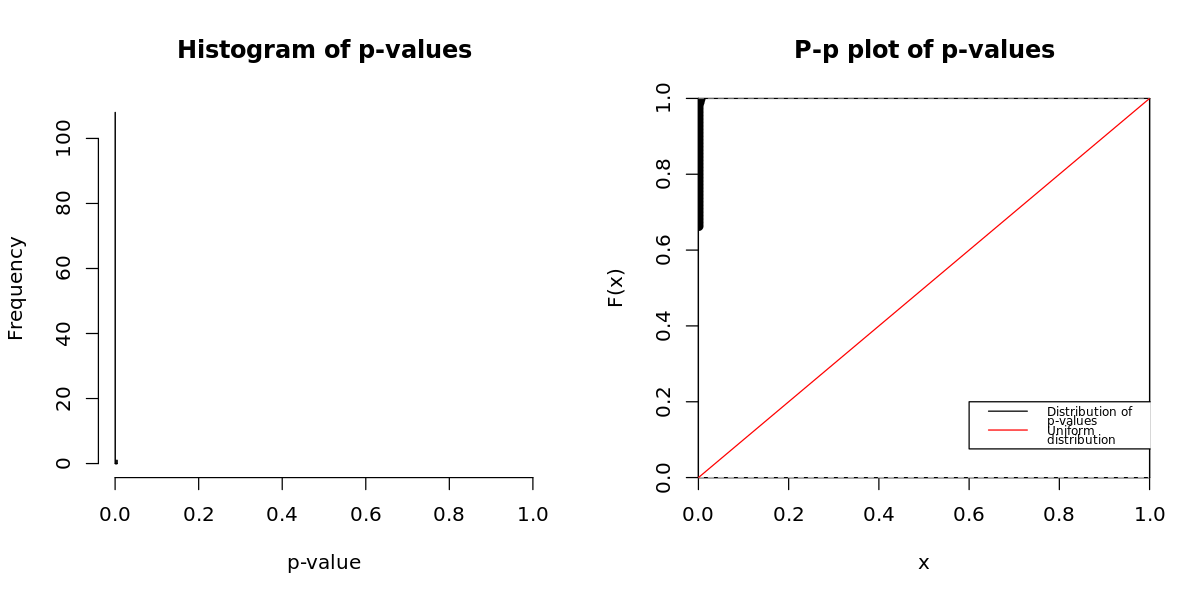

In [15]:
options(repr.plot.width=10, repr.plot.height=5)
plot(test.td)

In [16]:
test.td$fdr=p.adjust(test.td$pvalue,method="fdr")
test.td$bonferroni=p.adjust(test.td$pvalue,method="bonferroni")
table(test.td$conclusion,test.td$fdr<0.01,test.td$bonferroni<0.01)

, ,  = FALSE

                 
                  TRUE
  Overenrichment     2
  Underenrichment    1

, ,  = TRUE

                 
                  TRUE
  Overenrichment    29
  Underenrichment   78


In [17]:
Test.td=subset(test.td[order(-test.td$nab),], conclusion=="Overenrichment" & fdr<0.01)
table(Test.td$A,Test.td$B)

                        
                         I II III IV IX V VI VII VIII X XI
  brown_sporophytes.down 0  1   0  0  0 1  0   0    1 0  0
  brown_sporophytes.up   0  0   0  0  1 0  0   1    0 0  1
  gametophores.down      1  0   0  0  1 1  0   1    0 0  0
  gametophores.up        0  1   0  0  0 0  0   0    0 1  0
  green_sporophytes.down 0  1   0  0  0 1  0   0    1 0  0
  green_sporophytes.up   1  0   1  0  0 0  0   1    0 1  1
  protonema.down         1  0   0  0  0 0  0   0    0 1  1
  protonema.up           0  0   0  0  0 1  0   0    1 0  0
  spores.down            0  1   0  0  0 0  0   0    0 1  1
  spores.up              1  0   0  0  0 1  0   0    1 0  0

In [18]:
col=read.delim("subnetwork_colours.csv",sep=",",stringsAsFactors=FALSE)
col2=as.character(col$colour)
names(col2)=col$network
col2

I        II       III        IV         V        VI       VII      VIII 
"#999999" "#FFE529" "#5A6A99" "#FF7F00" "#E486B7" "#6B886E" "#E41A1C" "#CA9A2C" 
       IX         X        XI 
"#AD5882" "#C66764" "#449B76"

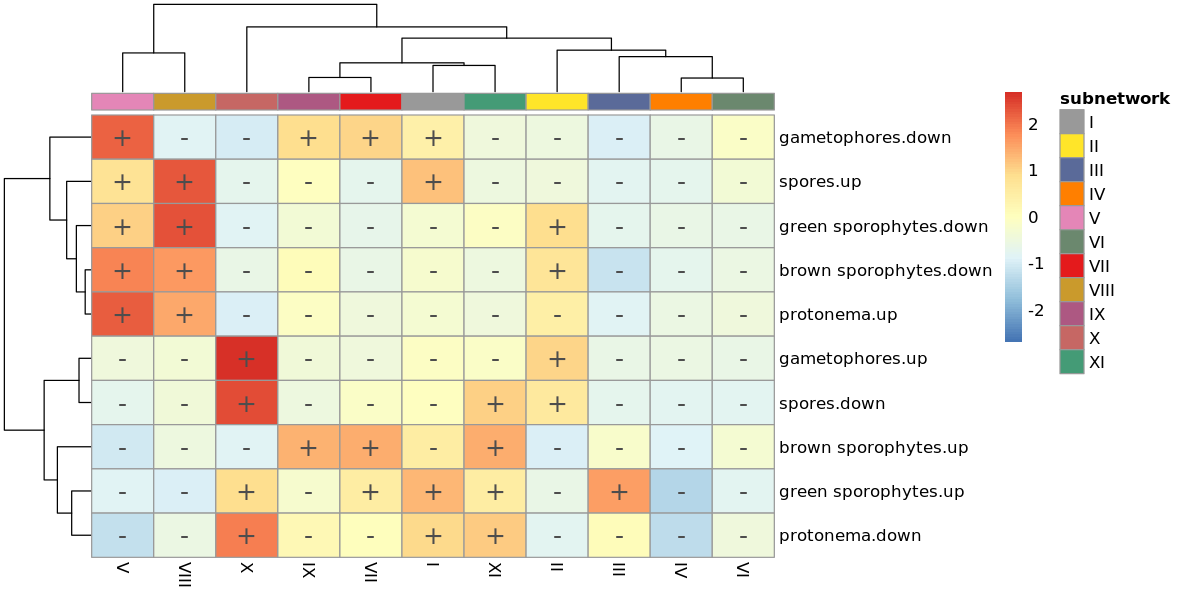

In [20]:
x=test.td
x$var=x$nab/x$expected_nab
X=dcast(x,A~B,value.var="var")
row.names(X)=gsub("_"," ",X[,1])
X=X[,-1]
x$var2=ifelse(x$fdr<0.01,ifelse(x$conclusion=="Overenrichment","+","-"),"")
XX=dcast(x,A~B,value.var="var2")
row.names(XX)=gsub("_"," ",XX[,1])
XX=XX[,-1]
net=data.frame(subnetwork=as.character(col$network))
row.names(net)=col$network
options(repr.plot.width=10, repr.plot.height=5)
pheatmap(mat=X,scale="row",
         annotation_col=net,
         annotation_names_row = FALSE, annotation_names_col = FALSE,
         annotation_colors=list(subnetwork=col2),
         annotation_legend=TRUE,
         clustering_method="ward.D2",
         display_numbers=XX,
         fontsize_number=15,
         width=10,
         height=5
        )

In [22]:
x=test.td
x$var=x$nab/x$expected_nab
X=dcast(x,A~B,value.var="var")
row.names(X)=gsub("vs","vs.",gsub("\\."," ",gsub("_"," ",X[,1])))
X=X[,-1]
x$var2=ifelse(x$fdr<0.01,ifelse(x$conclusion=="Overenrichment","+","-"),"")
XX=dcast(x,A~B,value.var="var2")
row.names(XX)=gsub("vs","vs.",gsub("\\."," ",gsub("_"," ",XX[,1])))
XX=XX[,-1]
net=data.frame(subnetwork=as.character(col$network))
row.names(net)=col$network
pheatmap(mat=X,scale="row",
         annotation_col=net,
         annotation_names_row = FALSE, annotation_names_col = FALSE,
         annotation_colors=list(subnetwork=col2),
         annotation_legend=TRUE,
         clustering_method="ward.D2",
         display_numbers=XX,
         fontsize_number=15,
         width=10,
         height=4,
         filename="NEAT_subnetwork_enrichment.gene_atlas_DGE_development.pdf"
        )